In [19]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
lr = 0.001
BATCH_SIZE = 512
epochs = 10
num_classes = 10

In [21]:
transform = transforms.ToTensor()

# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5), (0.5))
# ]) # Make pixel range [-1, 1]

train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE)

In [4]:
images, labels = next(iter(train_dataloader))
print(torch.min(images), torch.max(images))

tensor(0.) tensor(1.)


In [5]:
image_size = images[0].shape[1]
image_size

28

In [6]:
num_classes = len(train_data.classes)
num_classes

10

In [7]:
print(images.reshape(-1, image_size*image_size).shape)
print(images.flatten(1).shape)

torch.Size([512, 784])
torch.Size([512, 784])


In [8]:
class LinearAutoEncoder(nn.Module):
  def __init__(self, image_size):
    super().__init__()

    self.encoder = nn.Sequential(
        nn.Linear(in_features=image_size*image_size,
                  out_features=128), # (N, image_size * image_size)
        nn.ReLU(),
        nn.Linear(in_features=128,
                  out_features=64),
        nn.ReLU(),
        nn.Linear(in_features=64,
                  out_features=12),
        nn.ReLU(),
        nn.Linear(in_features=12,
                  out_features=3) # (N, 3)
    )

    self.decoder = nn.Sequential(
        nn.Linear(in_features=3,
                  out_features=12), # (N, 3)
        nn.ReLU(),
        nn.Linear(in_features=12,
                  out_features=64),
        nn.ReLU(),
        nn.Linear(in_features=64,
                  out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128,
                  out_features=image_size*image_size), # (N, image_size * image_size)
        nn.Sigmoid() # We want the output to be in the range [0, 1]
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [9]:
model = LinearAutoEncoder(image_size=image_size).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr, weight_decay=1e-5)

In [10]:
outputs = []

model.train()

for epoch in tqdm(range(epochs), desc="Training", leave=False):
  train_loss = 0

  for i, (img, label) in tqdm(enumerate(train_dataloader)):
    img = img.flatten(1).to(device)

    recon = model(img)
    loss = loss_fn(recon, img)
    train_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f"Epoch: {epoch + 1} | Loss: {train_loss / len(train_dataloader)}")
  outputs.append((epoch, img.cpu().detach().numpy(), recon.cpu().detach().numpy()))

Training:   0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch: 1 | Loss: 0.09391650071336051


0it [00:00, ?it/s]

Epoch: 2 | Loss: 0.06029948696367821


0it [00:00, ?it/s]

Epoch: 3 | Loss: 0.05621242958862903


0it [00:00, ?it/s]

Epoch: 4 | Loss: 0.052797227876923855


0it [00:00, ?it/s]

Epoch: 5 | Loss: 0.04757228433707003


0it [00:00, ?it/s]

Epoch: 6 | Loss: 0.04477099341861272


0it [00:00, ?it/s]

Epoch: 7 | Loss: 0.043105498713962104


0it [00:00, ?it/s]

Epoch: 8 | Loss: 0.0419609497727479


0it [00:00, ?it/s]

Epoch: 9 | Loss: 0.041066856865408057


0it [00:00, ?it/s]

Epoch: 10 | Loss: 0.04037684208508265


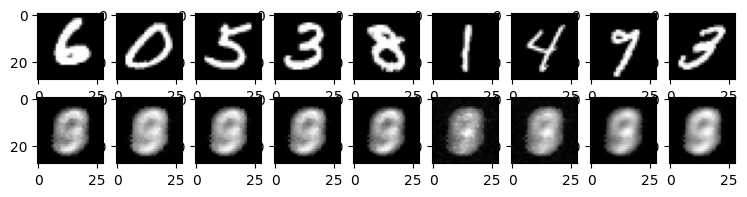

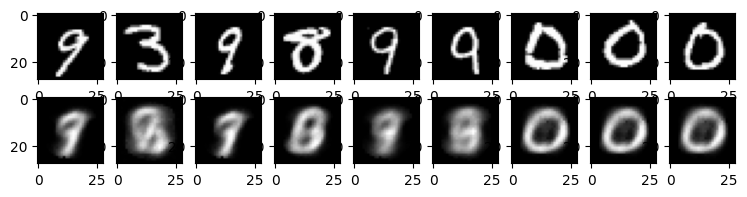

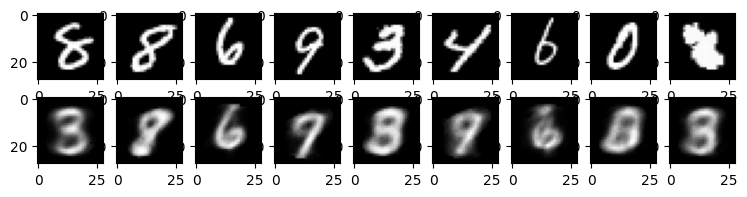

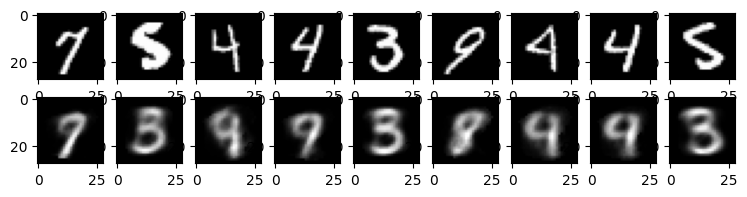

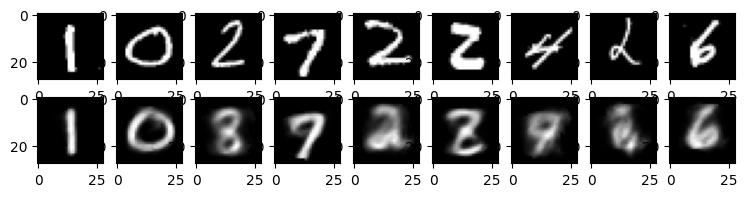

In [11]:
model.eval()

with torch.inference_mode():
  for i in range(0, epochs, 2):
    plt.figure(figsize=(9, 2))
    plt.gray()

    imgs = outputs[i][1]
    recons = outputs[i][2]

    for i, item in enumerate(imgs):
      if i >= 9: break
      plt.subplot(2, 9, i + 1)
      item = item.reshape(-1, image_size, image_size) # Reshape to (batch_size, H, W)
      plt.imshow(item[0])

    for i, item in enumerate(recons):
      if i >= 9: break
      plt.subplot(2, 9, i + 10)
      item = item.reshape(-1, image_size, image_size) # Reshape to (batch_size, H, W)
      plt.imshow(item[0])

In [12]:
class CNNAutoEncoder(nn.Module):
  def __init__(self, image_size):
    super().__init__()

    # (N, 1, image_size, image_size)
    self.encoder = nn.Sequential(
        nn.Conv2d(in_channels=1,
                  out_channels=16,
                  kernel_size=3,
                  stride=2,
                  padding=1), # (N, 16, image_size / 2, image_size / 2)
        nn.ReLU(),
        nn.Conv2d(in_channels=16,
                  out_channels=32,
                  kernel_size=3,
                  stride=2,
                  padding=1), # (N, 32, image_size / 4, image_size / 4)
        nn.ReLU(),
        nn.Conv2d(in_channels=32,
                  out_channels=64,
                  kernel_size=7), # (N, 64, image_size / 28, image_size / 28)
    )

    # (N, 64, image_size / 28, image_size / 28)
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(in_channels=64,
                           out_channels=32,
                           kernel_size=7), # (N, 32, image_size / 4, image_size / 4)
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=32,
                           out_channels=16,
                           kernel_size=3,
                           stride=2,
                           padding=1,
                           output_padding=1), # (N, 16, image_size / 2, image_size / 2)
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=16,
                           out_channels=1,
                           kernel_size=3,
                           stride=2,
                           padding=1,
                           output_padding=1), # (N, 1, image_size, image_size)
        nn.Sigmoid() # We want the output to be in the range [0, 1]
    )

    # Note: If we use nn.MaxPool2d() in the Encoder, we have to use nn.MaxUnpool2d() in the decoder

  def forward(self, x):
    # x Shape: (N, 1, image_size, image_size)
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [13]:
model = CNNAutoEncoder(image_size=image_size).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr, weight_decay=1e-5)

In [14]:
outputs = []

model.train()

for epoch in tqdm(range(epochs), desc="Training", leave=False):
  train_loss = 0

  for i, (img, label) in tqdm(enumerate(train_dataloader)):
    img = img.to(device)

    recon = model(img)
    loss = loss_fn(recon, img)
    train_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f"Epoch: {epoch + 1} | Loss: {train_loss / len(train_dataloader)}")
  outputs.append((epoch, img.cpu().detach().numpy(), recon.cpu().detach().numpy()))

Training:   0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch: 1 | Loss: 0.08458118090185068


0it [00:00, ?it/s]

Epoch: 2 | Loss: 0.061135989819037714


0it [00:00, ?it/s]

Epoch: 3 | Loss: 0.025914223170128918


0it [00:00, ?it/s]

Epoch: 4 | Loss: 0.013315259013324976


0it [00:00, ?it/s]

Epoch: 5 | Loss: 0.00955451614523338


0it [00:00, ?it/s]

Epoch: 6 | Loss: 0.007697722933776045


0it [00:00, ?it/s]

Epoch: 7 | Loss: 0.0066128059535018975


0it [00:00, ?it/s]

Epoch: 8 | Loss: 0.0058783741423197216


0it [00:00, ?it/s]

Epoch: 9 | Loss: 0.005321231059003937


0it [00:00, ?it/s]

Epoch: 10 | Loss: 0.004891149427394493


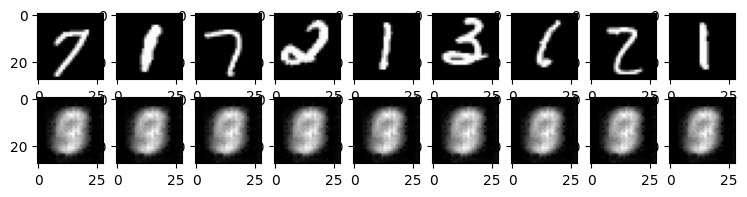

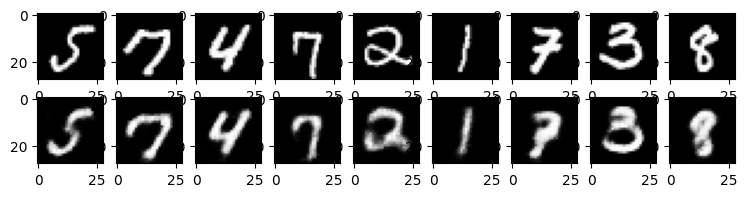

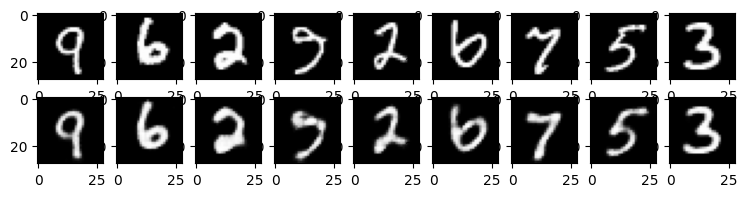

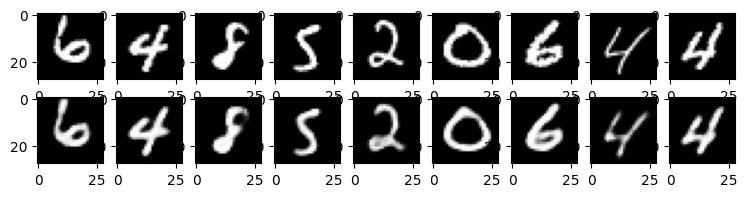

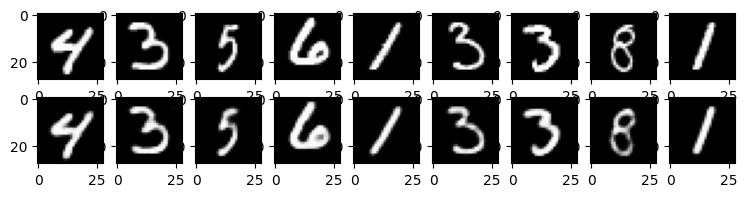

In [15]:
model.eval()

with torch.inference_mode():
  for i in range(0, epochs, 2):
    plt.figure(figsize=(9, 2))
    plt.gray()

    imgs = outputs[i][1]
    recons = outputs[i][2]

    for i, item in enumerate(imgs):
      if i >= 9: break
      plt.subplot(2, 9, i + 1)
      plt.imshow(item[0])

    for i, item in enumerate(recons):
      if i >= 9: break
      plt.subplot(2, 9, i + 10)
      plt.imshow(item[0])

In [16]:
latent_space_representations = []
labels_list = []

for i, (img, label) in tqdm(enumerate(train_dataloader)):
  img = img.to(device)

  latent_space = model.encoder(img)
  latent_space_representations.append(latent_space.cpu().detach().numpy())
  labels_list.append(label)

print(len(latent_space_representations))

0it [00:00, ?it/s]

118


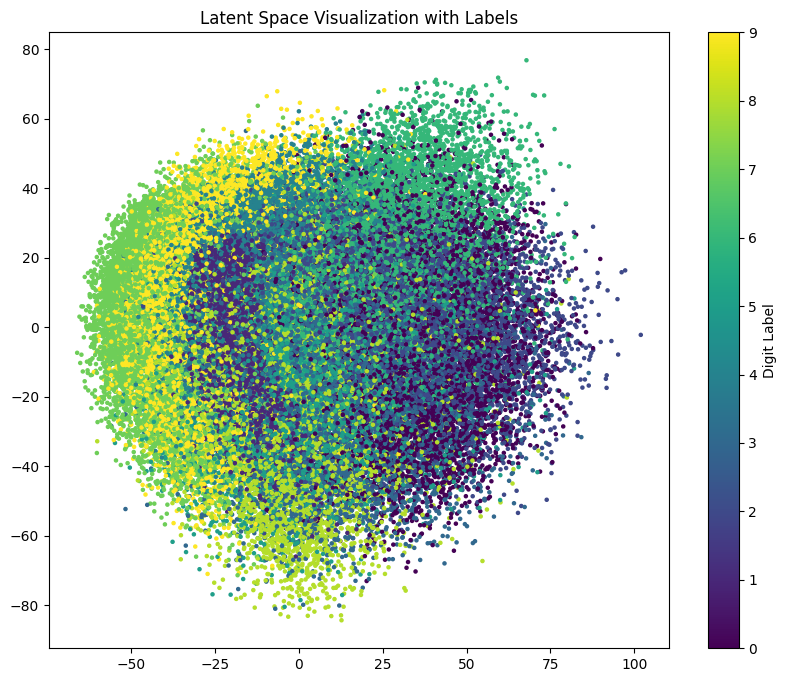

In [17]:
from sklearn.decomposition import PCA

# Concatenate the latent space representations and labels
latent_space_flattened = np.concatenate([x.reshape(x.shape[0], -1) for x in latent_space_representations], axis=0)
labels_flattened = np.concatenate(labels_list, axis=0)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(latent_space_flattened)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels_flattened, cmap='viridis', s=5)
plt.title("Latent Space Visualization with Labels")
plt.colorbar(scatter, label='Digit Label')
plt.show()

In [40]:
test_images = next(iter(test_dataloader))[0]
test_images.shape

torch.Size([512, 1, 28, 28])

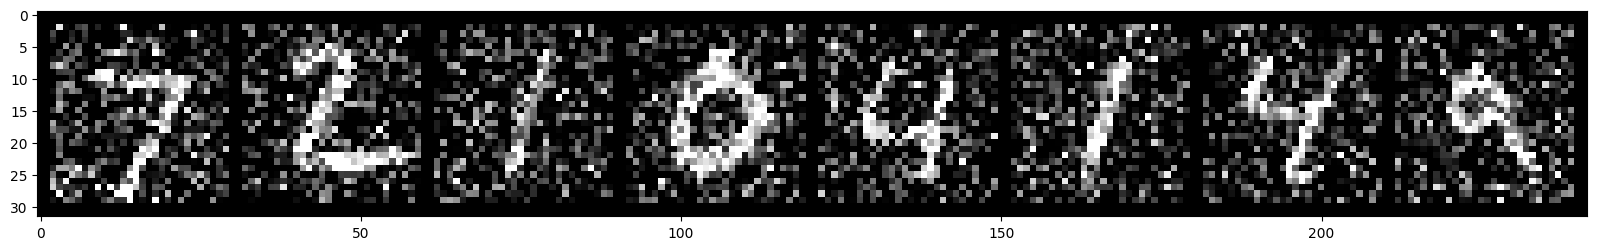

In [60]:
# Generate noisy images
noise_scale = 0.4

# Generate Gaussian noise (mean=0, std=noise_scale)
noise = noise_scale * torch.randn_like(test_images)
noisy_test_img = test_images + noise

noisy_test_img = torch.clamp(noisy_test_img, 0, 1) # Clamp between the range of [0, 1]

out = vutils.make_grid(noisy_test_img[:8], normalize=True)
plt.figure(figsize=(20, 10))
plt.imshow(out.cpu().numpy().transpose((1, 2, 0)))
plt.show()

In [61]:
noisy_test_img.shape

torch.Size([512, 1, 28, 28])

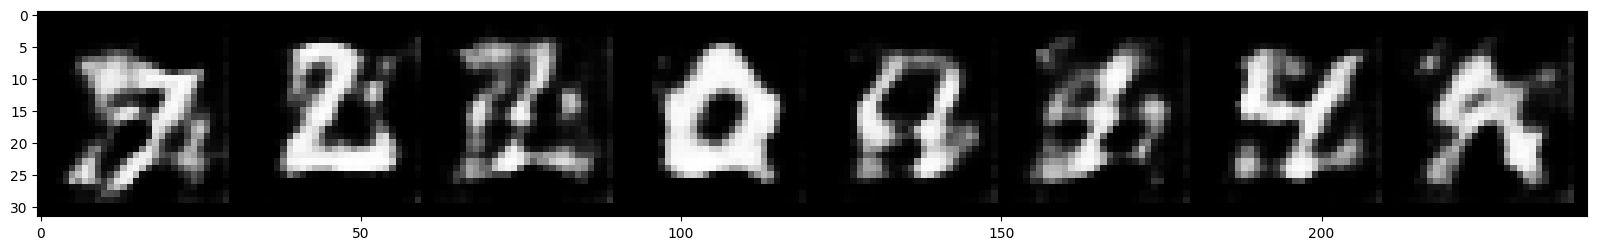

In [62]:
# Reconstruction
plt.figure(figsize = (20,10))
recon_data = model(noisy_test_img.to(device))
out = vutils.make_grid(recon_data.detach().cpu()[0:8], normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))